# Network Traffic Time Series Analysis

by Ivan Li

## Introduction

Cloud computing has revolutionized the way people interact with digital resources. It has experienced exponential growth over the past decade, and as more operations move to the cloud, ensuring a secure service has become crucial. One key challenge is identifying and mitigating anomalies, such as sudden spikes in traffic, Distributed Denial of Service (DDoS) attacks, or unexpected server overloads. An effective anomaly detection model is able to monitor network traffic, flag irregular patterns, and aid in providing real-time solutions.


## Motivation

The need for anomaly detection arises from two big risks in any server based environment:

1. Malicious Attacks: Hackers often exploit vulnerabilities in servers to launch DDoS attacks, which flood networks with requests, causing downtime and disrupting services.

2. Server Overload: Non-malicious traffic surges can overwhelm servers. Preparing for such scenarios is critical to maintain service availability.

Identifying abnormal patterns in real time allows for timely intervention and mitigation.

## What Can Be Done?

To help solve these problems, machine learning time series models can be trained on network traffic data to:

- Detection and Warning: Live, automatic anomaly detection allows for early warnings, reducing manual oversight and allowing for faster solution deployment.

- Enhance preparedness: Forecasting patterns in network traffic can help to prepare businesses and companies for increased network load.

## What is Ping?

Ping is a numeric measure of the response time of a server or network.

Normal Traffic: A single instance of high ping typically results from client side issues such as connection lag or delays and does not necessarily indicate an attack.

Extended High Ping: In the context of video game servers, consistently high ping across all users over an extended period can signal issues such as a DDoS attack or server overload.

## Dataset Description

The dataset used for this project consists of real network traffic data from a single website server, available [here](https://www.kaggle.com/datasets/garystafford/ping-data). It contains the following:

- Ping measurements across several days

- Regular server requests

- Instances of extended high ping, indicating an attack or server overload

Specifically, the two variables that will be analyzed are in the table below.



| Variable   | Description                           |
|------------|---------------------------------------|
| timestamp  | Time of request                      |
| local_avg  | Average ping of all users at a given time |

## Methods

Two statistical and machine learning approaches are implemented to model the network traffic data and detect anomalies.

1. Prophet

  - Designed by Facebook for time-series forecasting
  - Captures trends, seasonality, and outliers
  - Good for data with regular patterns and occasional anomalies


2. ARIMA (Auto-Regressive Integrated Moving Average)

    - A classical time-series model
    - Models temporal tendencies
    - Good for detecting deviations in linear trends

## Results

The results for the implementation were done in Python on Google Colab, assuming that the dataset is on the user's google drive homepage.

Relevant graphics are generated, and interpretations are given after each graph.


#### Import all necessary libraries, and mount the user's drive if needed

In [2]:
# Import Libraries
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Data Preproccessing

Load in the data, isolate desired columns

In [4]:
# Read in data as dataframe
df = pd.read_csv('/content/drive/My Drive/ping_data.csv')

# Subset necessary columns
ping_data = df[['timestamp', 'local_avg']]

# Convert seconds to dates
ping_data['timestamp'] = pd.to_datetime(ping_data['timestamp'], unit='s')

# Subset data
ping_data = ping_data.iloc[:100]

<ipython-input-4-98138e6884b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ping_data['timestamp'] = pd.to_datetime(ping_data['timestamp'], unit='s')


#### Distribution of the dataset

The dataset can be visualized to get a better grasp of the relationship between time and ping.

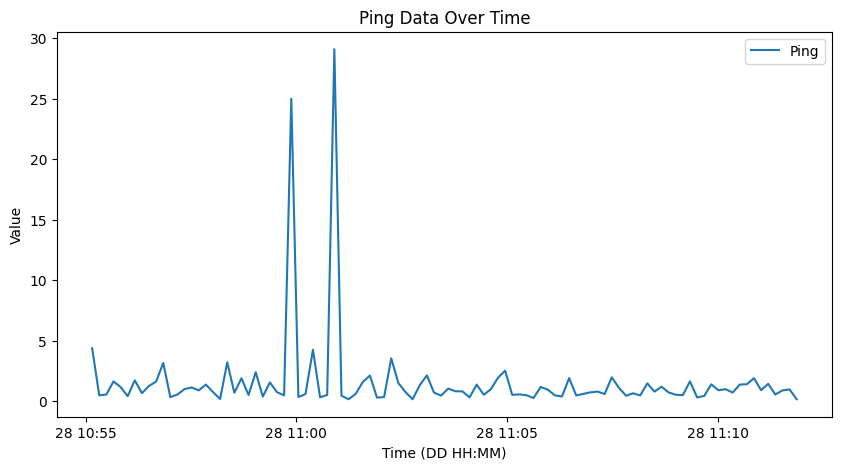

In [5]:
# Define X and Y variables for plotting
x = ping_data['timestamp']
y = ping_data['local_avg']

# Plot graph
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Ping')
plt.title('Ping Data Over Time')
plt.xlabel('Time (DD HH:MM)')
plt.ylabel('Value')
plt.legend()
plt.show()

From the graph, we see some clear abnormalities, potetially indicating high traffic volume.

Now, we can fit the time series models to the data.

### Prophet Model

In [6]:
# Split data into train and test
# 70% training (History), 30% test (To Forecast)
ping_data.rename(columns={'timestamp':'ds', 'local_avg': 'y'}, inplace=True)
train_size = int(0.7 * len(ping_data))
train = ping_data[:train_size]
test = ping_data[train_size:]

In [7]:
# Train Prophet model
model = Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0p7sy7kd/n2c988s8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0p7sy7kd/04sh2imp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75196', 'data', 'file=/tmp/tmp0p7sy7kd/n2c988s8.json', 'init=/tmp/tmp0p7sy7kd/04sh2imp.json', 'output', 'file=/tmp/tmp0p7sy7kd/prophet_modelcxw3o91g/prophet_model-20241202050702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:03 - cmdstanpy - INFO - Chai

In [8]:
# Predict on training data
train_forecast = model.predict(train[['ds']])

# Combine relevant columns into training data for plotting
train['yhat'] = train_forecast['yhat']
train['residuals'] = train['y'] - train['yhat']

<ipython-input-8-f155e066a410>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat'] = train_forecast['yhat']
<ipython-input-8-f155e066a410>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['residuals'] = train['y'] - train['yhat']


In [9]:
# Detect anomalies in training data using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Combine anomaly predictions to training data, and flag anomalies
train['anomaly'] = iso_forest.fit_predict(train[['residuals']])
train['anomaly'] = train['anomaly'] == -1  # Anomalies flagged as True

<ipython-input-9-30475ca8422e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['anomaly'] = iso_forest.fit_predict(train[['residuals']])
<ipython-input-9-30475ca8422e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['anomaly'] = train['anomaly'] == -1  # Anomalies flagged as True


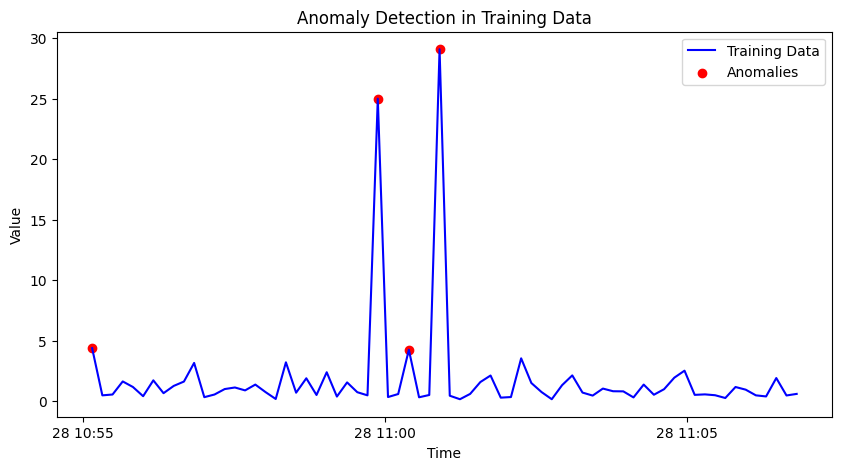

In [10]:
# Plot anomalies detected in training data
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.scatter(train['ds'][train['anomaly']], train['y'][train['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Training Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

At a glance, the algorithm seems to be doing well. It detects the obvious anomalies, and it also detects anomalies that are slightly higher than the desired ping values.

In [11]:
# Predict on test data
test_forecast = model.predict(test[['ds']])

# Combine relevant columns into test data for plotting
test['yhat'] = test_forecast.loc[test_forecast['ds'].isin(test['ds']), 'yhat'].values
test['residuals'] = test['y'] - test['yhat']

<ipython-input-11-4e4599735f17>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat'] = test_forecast.loc[test_forecast['ds'].isin(test['ds']), 'yhat'].values
<ipython-input-11-4e4599735f17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residuals'] = test['y'] - test['yhat']


In [12]:
# Detect anomalies in test data using Isolation Forest
test['anomaly'] = iso_forest.predict(test[['residuals']])

# Combine anomalies with test data and flag
test['anomaly'] = test['anomaly'] == -1  # Anomalies flagged as True

<ipython-input-12-aba8b109bbc6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['anomaly'] = iso_forest.predict(test[['residuals']])
<ipython-input-12-aba8b109bbc6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['anomaly'] = test['anomaly'] == -1  # Anomalies flagged as True


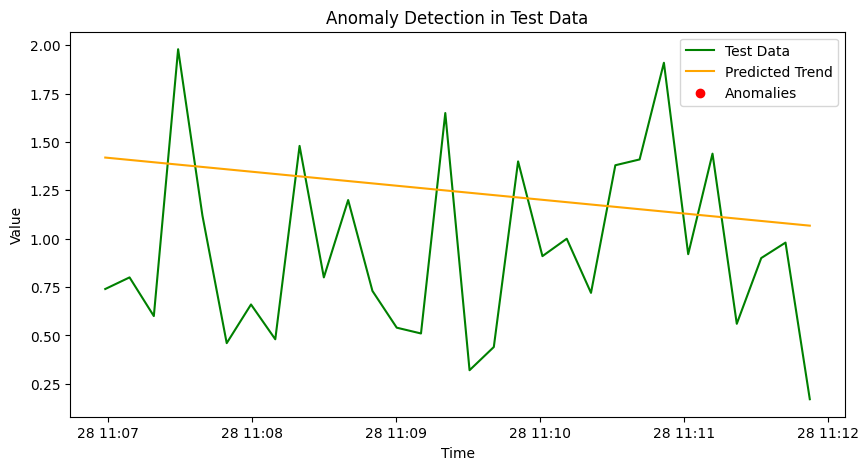

In [13]:
# Plot test anomaly detection, with predicted trend
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label='Test Data', color='green')
plt.plot(test['ds'], test['yhat'], label='Predicted Trend', color='orange')
plt.scatter(test['ds'][test['anomaly']], test['y'][test['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

The model didn't detect any anomalies in the testing data, which is expected, as they are all relatively low, desired values. The trend was not predicted very precisely, but the average trend was predicted well, with a clear negative correlation.

Now, we can fit an ARIMA model to the data.

The parameters for ARIMA are Autoregressive Order (p), Differencing Order (d), and Moving Average (q). The best parameters were chosen after experimentation and simulation.

In [47]:
# Define the ARIMA model
model = ARIMA(train['y'], order=(5,1,0)) # (p, q d)
model_fit = model.fit()

In [40]:
# Predict on training data
train['yhat'] = model_fit.predict(start=0, end=len(train)-1, typ='levels')
train['residuals'] = train['y'] - train['yhat']

<ipython-input-40-9474221a1308>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat'] = model_fit.predict(start=0, end=len(train)-1, typ='levels')
<ipython-input-40-9474221a1308>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['residuals'] = train['y'] - train['yhat']


In [41]:
# Detect anomalies in training data using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
train['anomaly'] = iso_forest.fit_predict(train[['residuals']])
train['anomaly'] = train['anomaly'] == -1  # Anomalies flagged as True

<ipython-input-41-d1be05363af9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['anomaly'] = iso_forest.fit_predict(train[['residuals']])
<ipython-input-41-d1be05363af9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['anomaly'] = train['anomaly'] == -1  # Anomalies flagged as True


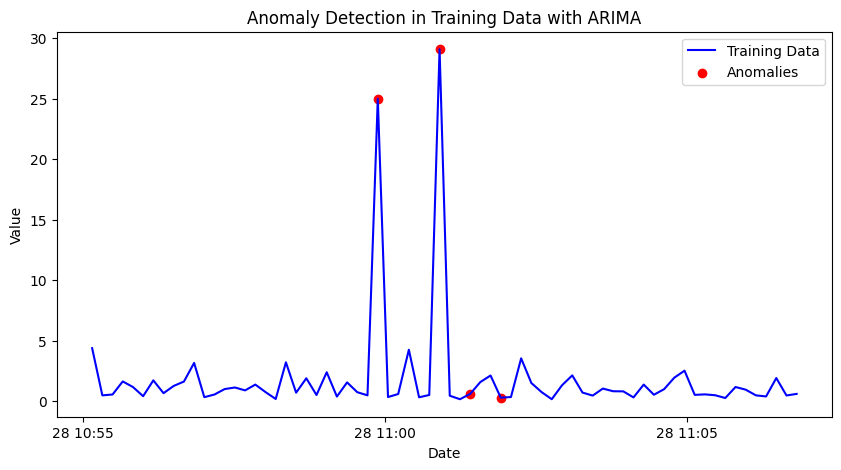

In [42]:
# Plot training anomalies
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.scatter(train['ds'][train['anomaly']], train['y'][train['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Training Data with ARIMA')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [43]:
# Predict on test data
test['yhat'] = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
test['residuals'] = test['y'] - test['yhat']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-43-1190580589e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat'] = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
<ipython-input-43-1190580589e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [44]:
# Detect anomalies in test data using Isolation Forest
test['anomaly'] = iso_forest.predict(test[['residuals']])
test['anomaly'] = test['anomaly'] == -1  # Anomalies flagged as True

<ipython-input-44-746d2f7ee122>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['anomaly'] = iso_forest.predict(test[['residuals']])
<ipython-input-44-746d2f7ee122>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['anomaly'] = test['anomaly'] == -1  # Anomalies flagged as True


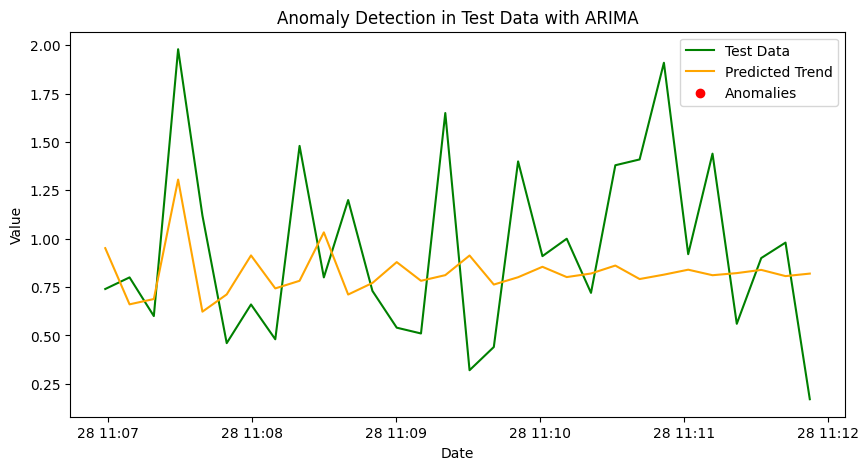

In [45]:
# Plot test anomalies
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label='Test Data', color='green')
plt.plot(test['ds'], test['yhat'], label='Predicted Trend', color='orange')
plt.scatter(test['ds'][test['anomaly']], test['y'][test['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Test Data with ARIMA')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

The ARIMA also didn't detect any anomalies, which was the expected result, and the same as the Prophet model. However ARIMA did a better job at modeling and forecasting the trend. For Prophet, we saw that it predicted a linear trend, while for ARIMA, the predicted trend resembles the actual pattern of the predicted data.